In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

Number of images in the train set :  14034
Number of images in the test set ;  3000
Number of images in prediction set :  7301


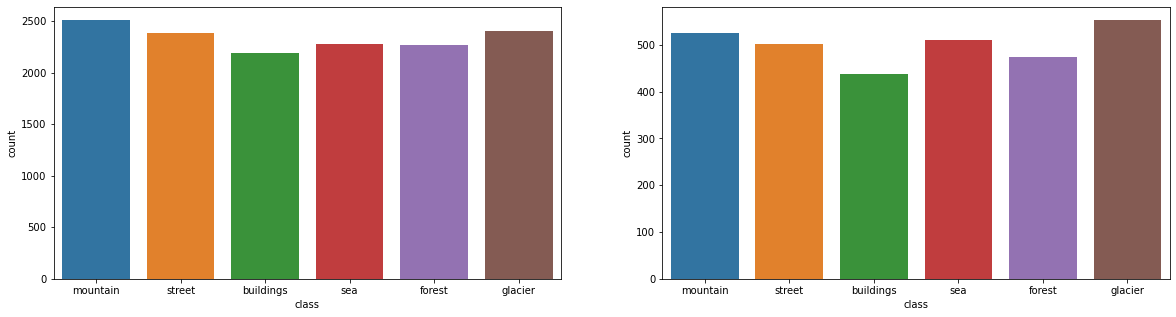

In [2]:
root_path = './input/intel-image-classification/'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = './input/intel-image-classification/seg_train/seg_train/' #one more seg_train folder within
seg_test_folders = './input/intel-image-classification/seg_test/seg_test/'
seg_pred_folders = './input/intel-image-classification/seg_pred/seg_pred/'
quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))

for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in prediction set : ",number_of_images_in_prediction_set)

plt.show()

In [3]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [4]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [5]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


In [6]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

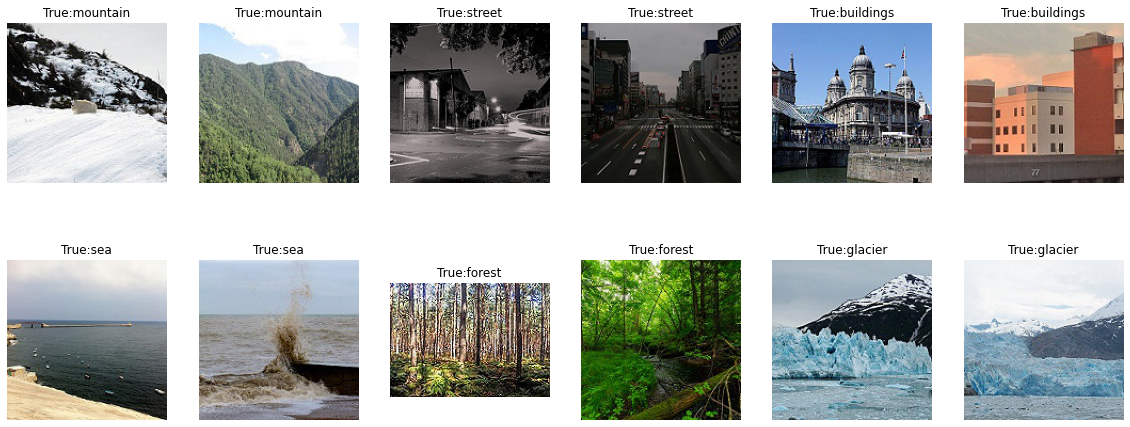

In [7]:
show_few_images(2)

In [8]:
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 60
vgg_epoch = 60
resnet_epoch = 60
inception_epoch = 60

In [9]:
#random architecture
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(6,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 144, 128)     18944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 67, 64)        204864    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8388736   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7

In [10]:
# plot_model(benchmark_model, to_file='model.png',show_shapes=True, show_layer_names=True)
# from IPython.display import FileLink
# FileLink(r'./resnet50_-saved-model-08-acc-0.75.hdf5')

Epoch 1/60
439/439 [==============================] - 191s 427ms/step - loss: 1.9895 - acc: 0.1804 - val_loss: 1.7903 - val_acc: 0.1750

Epoch 00001: val_acc improved from -inf to 0.17500, saving model to bench_mark_-model-01-0.17.hdf5
Epoch 2/60
439/439 [==============================] - 98s 223ms/step - loss: 1.7911 - acc: 0.1776 - val_loss: 1.7901 - val_acc: 0.1750

Epoch 00002: val_acc did not improve from 0.17500
Epoch 3/60
439/439 [==============================] - 98s 224ms/step - loss: 1.7903 - acc: 0.1839 - val_loss: 1.7901 - val_acc: 0.1750

Epoch 00003: val_acc did not improve from 0.17500
Epoch 4/60
439/439 [==============================] - 97s 221ms/step - loss: 1.7905 - acc: 0.1821 - val_loss: 1.7901 - val_acc: 0.1750

Epoch 00004: val_acc did not improve from 0.17500
Epoch 5/60
439/439 [==============================] - 96s 219ms/step - loss: 1.7912 - acc: 0.1776 - val_loss: 1.7902 - val_acc: 0.1750

Epoch 00005: val_acc did not improve from 0.17500
Epoch 6/60
439/439 [

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


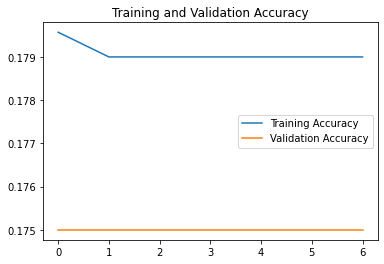

<Figure size 432x288 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


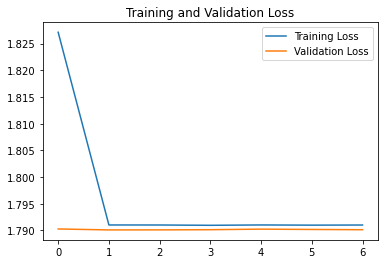

<Figure size 432x288 with 0 Axes>

In [11]:
filepath = "bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(train_generator,epochs=benchmark_epoch, verbose=1, validation_data = validation_generator,callbacks=[reduce_lr,early_stopping,checkpoint])

benchmark_model.save(filepath)
do_history_stuff(history, 'benchmark_model')


58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/60
439/439 [==============================] - 103s 233ms/step - loss: 0.8913 - acc: 0.6850 - val_loss: 0.4143 - val_acc: 0.8550

Epoch 00001: val_acc improved from -inf to 0.85500, saving model to vgg_16_-saved-model-01-acc-0.86.hdf5
Epoch 2/60
439/439 [==============================] - 102s 232ms/step - loss: 0.4468 - acc: 0.8289 - val_loss: 0.4131 - val_acc: 0.8473

Epoch 00002: val_acc did not improve from 0.85500
Epoch 3/60
439/439 [==============================] - 102s 232ms/step - loss: 0.3988 - acc: 0.8577 - val_loss: 0.3711 - val_acc: 0.8643

Epoch 00003: val_acc improved from 0.85500 to 0.86433, saving model to vgg_16_-saved-model-03-acc-0.86.hdf5
Epoch 4/60
439/439 [==============================] - 102s 232ms/step - loss: 0.3795 - acc: 0.8627 - val_loss: 0.3680 - val_acc: 0.8617

Epoch 00004: val_acc did not improve from 0.86433
Epoch 5/60
439/439 [==============================] - 103s 235ms/step - lo

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


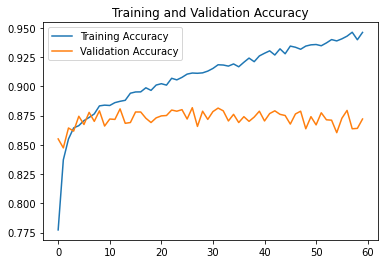

<Figure size 432x288 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


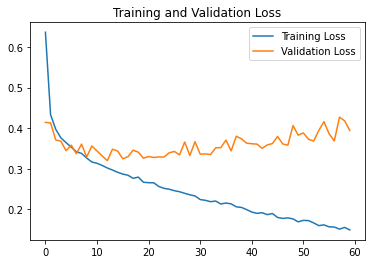

<Figure size 432x288 with 0 Axes>

In [12]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(6, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)

do_history_stuff(vgg16_history, 'vgg16_model')

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/60
439/439 [==============================] - 137s 301ms/step - loss: 1.3383 - acc: 0.7384 - val_loss: 2.6677 - val_acc: 0.1970

Epoch 00001: val_acc improved from -inf to 0.19700, saving model to resnet50-saved-model-01-val_acc-0.20.hdf5
Epoch 2/60
439/439 [==============================] - 135s 308ms/step - loss: 0.2245 - acc: 0.9191 - val_loss: 0.5448 - val_acc: 0.8297

Epoch 00002: val_acc improved from 0.19700 to 0.82967, saving model to resnet50-saved-model-02-val_acc-0.83.hdf5
Epoch 3/60
439/439 [==============================] - 136s 310ms/step - loss: 0.1309 - acc: 0.9522 - val_loss: 0.3910 - val_acc: 0.8677

Epoch 00003: val_acc improved from 0.82967 to 0.86767, saving model to resnet50-saved-model-03-val_acc-0.87.hdf5
Epoch 4/60
439/439 [==============================] - 137s 312ms/step - loss: 0.0937 - acc: 0.9672 - val_loss: 0.3908 - val_acc: 0.8760

Epoch 00004: val_acc improved from 0.86767 to 0.876

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


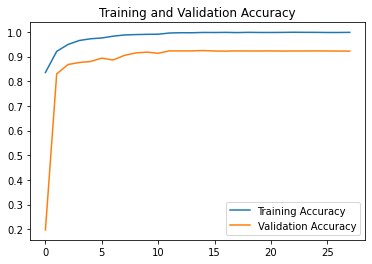

<Figure size 432x288 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


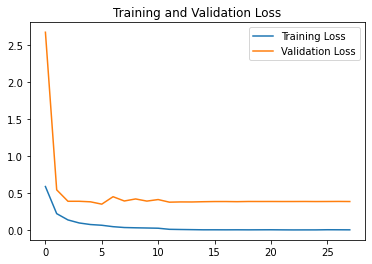

<Figure size 432x288 with 0 Axes>

In [13]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=6)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(6,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/60
439/439 [==============================] - 137s 301ms/step - loss: 1.2154 - accuracy: 0.5491 - val_loss: 0.3928 - val_accuracy: 0.8633
Epoch 2/60
439/439 [==============================] - 139s 315ms/step - loss: 0.4548 - accuracy: 0.8429 - val_loss: 0.3252 - val_accuracy: 0.8773
Epoch 3/60
439/439 [==============================] - 137s 313ms/step - loss: 0.3889 - accuracy: 0.8668 - val_loss: 0.2863 - val_accuracy: 0.8920
Epoch 4/60
439/439 [==============================] - 138s 313ms/step - loss: 0.3400 - accuracy: 0.8800 - val_loss: 0.2698 - val_accuracy: 0.9020
Epoch 5/60
439/439 [==============================] - 137s 313ms/step - loss: 0.3149 - accuracy: 0.8868 - val_loss: 0.2606 - val_accuracy: 0.9043
Epoch 6/60
439/439 [==============================] - 138s 314ms/step - loss: 0.2837 - accuracy: 0.8986 - val_loss: 0.2582 - val_accuracy: 0.9053
Epoch 7/60
439/439 [==============================] - 137s 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


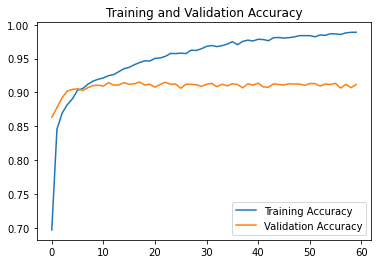

<Figure size 432x288 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


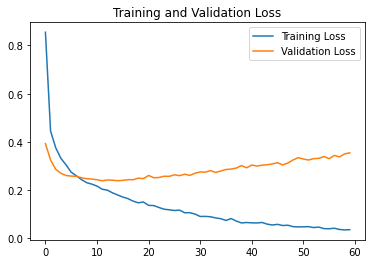

<Figure size 432x288 with 0 Axes>

In [14]:
# this could also be the output a different Keras model or layer

InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(6, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)  

### Combining the best models of VGG16, Resnet50 & InceptionV3

In [15]:
#vgg_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/vgg_16_-saved-model-15-acc-0.88.hdf5')
#resnet_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/resnet50-saved-model-11-val_acc-0.92.hdf5')
#inception_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/inceptionv3_-saved-model-03-loss-0.22.hdf5')
#benchmark_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/bench_mark_-model-18-0.79.hdf5')
vgg_best_model = vgg16_final_model 
resnet_best_model = resnet50_x_final_model
inception_best_model = InceptionV3_x_final_model 

In [16]:

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
for folder in os.listdir(seg_test_folders):
    
    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(seg_test_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255
        #vgg
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        
        #resnet50
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)
        
        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)
        
        #benchmark
        benchmark_model_prediction = np.argmax(benchmark_model.predict(np.array([img_normalized])))
        benchmark_model_pred.append(benchmark_model_prediction)
        
        #giving vgg16 high priority if they all predict something different
        image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])                                  
        combined_model_pred.append(image_prediction)

In [17]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

Model Accuracy 0.175
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
      forest       0.00      0.00      0.00       474
     glacier       0.00      0.00      0.00       553
    mountain       0.17      1.00      0.30       525
         sea       0.00      0.00      0.00       510
      street       0.00      0.00      0.00       501

    accuracy                           0.17      3000
   macro avg       0.03      0.17      0.05      3000
weighted avg       0.03      0.17      0.05      3000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


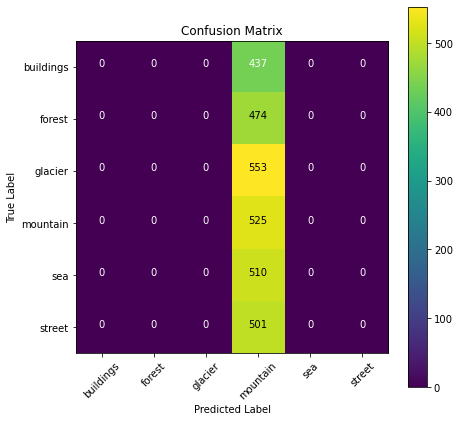

In [18]:
#benchmark model
clf_report(true_value, benchmark_model_pred)

Model Accuracy 0.8723333333333333
              precision    recall  f1-score   support

   buildings       0.91      0.93      0.92       437
      forest       0.98      0.99      0.98       474
     glacier       0.78      0.80      0.79       553
    mountain       0.83      0.66      0.73       525
         sea       0.83      0.95      0.89       510
      street       0.93      0.94      0.93       501

    accuracy                           0.87      3000
   macro avg       0.88      0.88      0.87      3000
weighted avg       0.87      0.87      0.87      3000



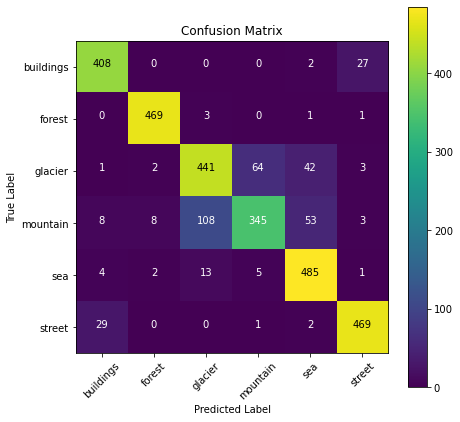

In [19]:
#combined vote
combined_model_pred = [ c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

Model Accuracy 0.848
              precision    recall  f1-score   support

   buildings       0.86      0.91      0.88       437
      forest       0.95      0.98      0.97       474
     glacier       0.78      0.74      0.76       553
    mountain       0.77      0.69      0.73       525
         sea       0.83      0.91      0.87       510
      street       0.91      0.89      0.90       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



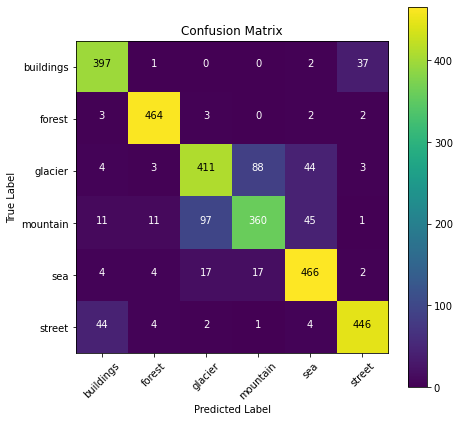

In [20]:
# VGG model classification report
clf_report(true_value, vgg_pred)

Model Accuracy 0.8476666666666667
              precision    recall  f1-score   support

   buildings       0.89      0.92      0.91       437
      forest       0.97      0.99      0.98       474
     glacier       0.75      0.77      0.76       553
    mountain       0.81      0.62      0.70       525
         sea       0.76      0.89      0.82       510
      street       0.92      0.93      0.93       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.84      3000



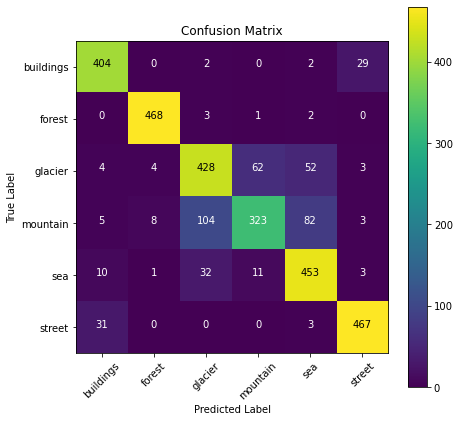

In [21]:
# Resnet50 model classification report
clf_report(true_value, resnet_pred)

Model Accuracy 0.8273333333333334
              precision    recall  f1-score   support

   buildings       0.90      0.92      0.91       437
      forest       0.99      0.98      0.98       474
     glacier       0.67      0.73      0.70       553
    mountain       0.77      0.53      0.63       525
         sea       0.76      0.93      0.83       510
      street       0.93      0.91      0.92       501

    accuracy                           0.83      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.83      0.83      0.82      3000



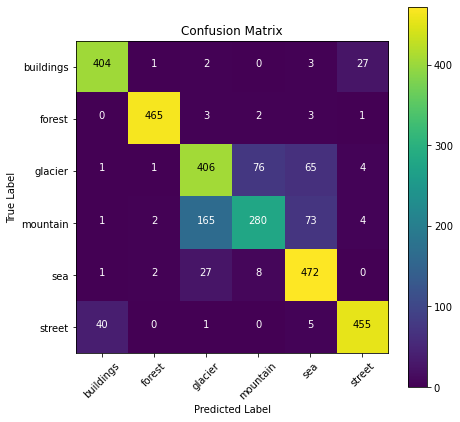

In [22]:
# Inception model classification report
clf_report(true_value, inception_pred)

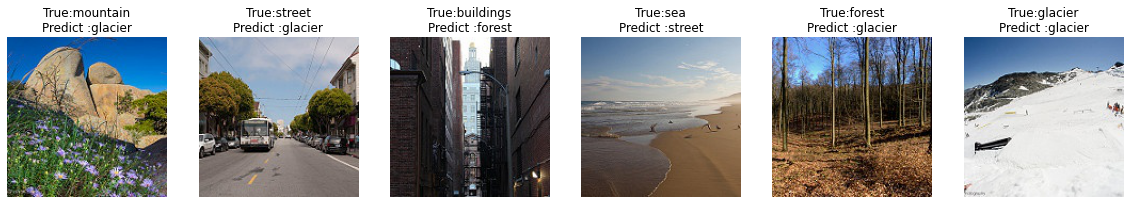

In [23]:
show_few_images(1,benchmark_model_pred)

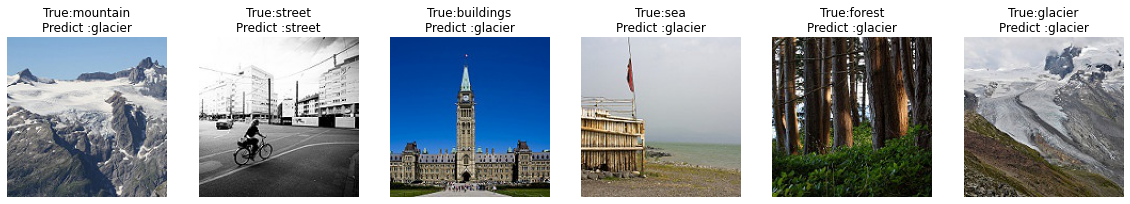

In [24]:
show_few_images(1,vgg_pred)

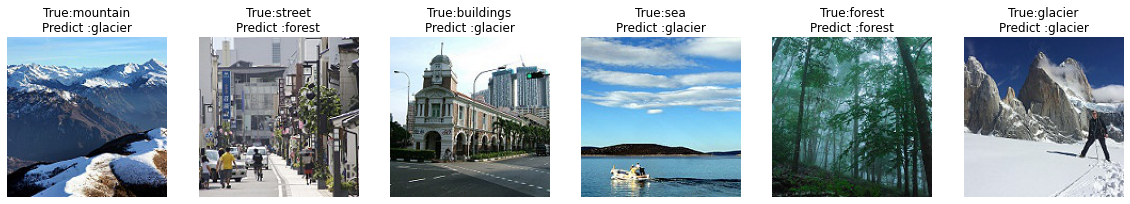

In [25]:
show_few_images(1,resnet_pred)

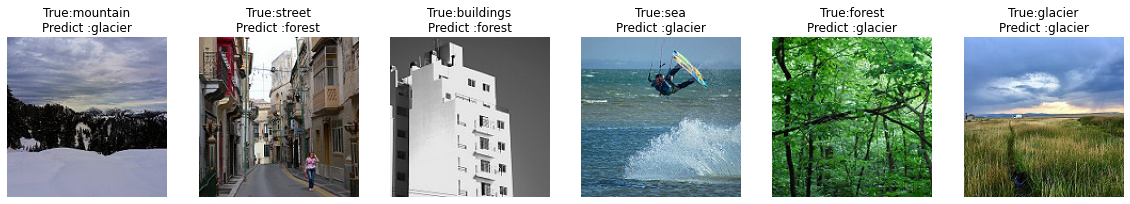

In [26]:
show_few_images(1,inception_pred)

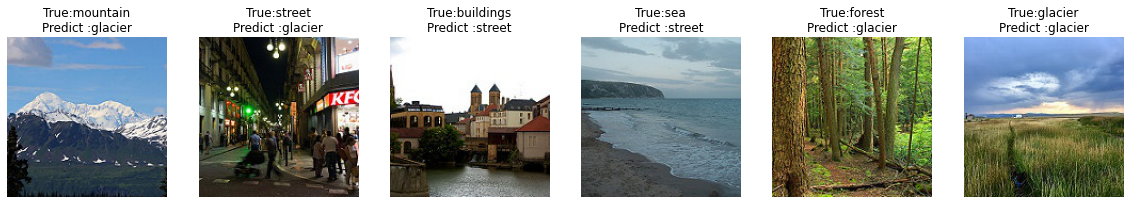

In [27]:
show_few_images(1,combined_model_pred)